# Exploratory data analysis

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re

In [2]:
filepath = "/Users/rodolfo.saldanha/Desktop/labelled_text.csv"
data = pd.read_csv(filepath, header=None)
data.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [3]:
data.columns = ["user_id", "game", "sentiment", "comment"]
data

,user_id,game,sentiment,comment
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [4]:
data.comment = data.comment.str.lower()
data.drop_duplicates(["user_id", "game", "sentiment", "comment"], inplace=True)

In [5]:
data.shape

(71739, 4)

In [6]:
sentiment_distribution = data["sentiment"].value_counts()
sentiment_distribution

Negative      21718
Positive      19717
Neutral       17758
Irrelevant    12546
Name: sentiment, dtype: int64

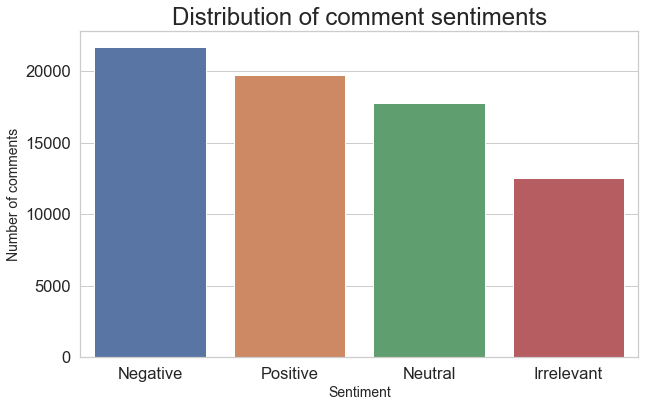

In [7]:
sns.set(font_scale = 1.5)
sns.set_style("whitegrid") 
plt.figure(figsize=(10,6))

sns.barplot(x=sentiment_distribution.index, y=sentiment_distribution.values)
plt.title("Distribution of comment sentiments", fontsize=24)
plt.ylabel("Number of comments", fontsize=14)
plt.xlabel("Sentiment", fontsize=14)

plt.show()

In [8]:
data["positive"] = 0
data["negative"] = 0
data["neutral"] = 0
data["irrelevant"] = 0
data.loc[data["sentiment"].str.lower() == "positive", ["positive"]] = 1
data.loc[data["sentiment"].str.lower() == "negative", ["negative"]] = 1
data.loc[data["sentiment"].str.lower() == "neutral", ["neutral"]] = 1
data.loc[data["sentiment"].str.lower() == "irrelevant", ["irrelevant"]] = 1

In [9]:
data.head()

,user_id,game,sentiment,comment,positive,negative,neutral,irrelevant
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,1,0,0,0
1,2401,Borderlands,Positive,i am coming to the borders and i will kill you...,1,0,0,0
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,1,0,0,0
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,1,0,0,0
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,1,0,0,0


In [10]:
boxplot = data.copy()
boxplot["comment_length"] = data.comment.apply(lambda x: len(str(x)))

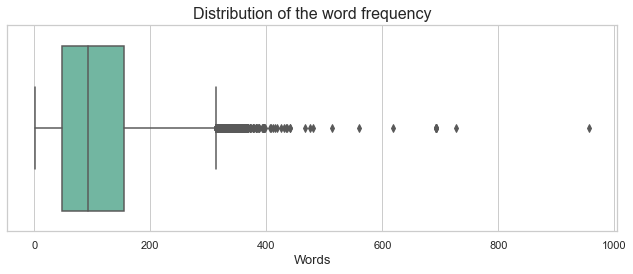

In [11]:
sns.set(style="whitegrid",rc={"font.size":13,"axes.labelsize":13})

plt.figure(figsize=(9, 4))

ax = sns.boxplot(x="comment_length", data=boxplot, orient="h", palette="Set2")
plt.ylabel("")
plt.xlabel("Words")
plt.title("Distribution of the word frequency", fontsize=16)
plt.tight_layout(h_pad=3)

# Preprocessing

In [12]:
def remove_stop_words(sentence):
    global re_stop_words
    return re_stop_words.sub("", sentence)

def decontract(token):
    token = re.sub(r"won't", "will not", token)
    token = re.sub(r"can\'t", "can not", token)
    token = re.sub(r"n\'t", " not", token)
    token = re.sub(r"\'re", " are", token)
    token = re.sub(r"\'s", " is", token)
    token = re.sub(r"\'d", " would", token)
    token = re.sub(r"\'ll", " will", token)
    token = re.sub(r"\'t", " not", token)
    token = re.sub(r"\'ve", " have", token)
    token = re.sub(r"\'m", " am", token)
    return token

def remove_punctuation(token): 
    token = re.sub(r'[?|!|\'|"|#]',r'',token)
    token = re.sub(r'[.|,|)|(|\|/]',r' ',token)
    token = token.strip()
    token = token.replace("\n"," ")
    return token

In [13]:
stemmer = SnowballStemmer("english")
def stem(token):
    stem_token = ""
    for word in token.split():
        stem = stemmer.stem(word)
        stem_token += stem
        stem_token += " "
    stem_token = stem_token.strip()
    return stem_token

In [14]:
stopwords= set(['br', 'the', 'i', 'im', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

re_stop_words = re.compile(r"\b(" + "|".join(stopwords) + ")\\W", re.I)

In [15]:
data.comment = data.comment.apply(lambda x: decontract(str(x)))
data.comment = data.comment.apply(remove_stop_words)
data.comment = data.comment.apply(remove_punctuation)
data["comment"] = data.comment.apply(stem)
data.head()

,user_id,game,sentiment,comment,positive,negative,neutral,irrelevant
0,2401,Borderlands,Positive,get borderland murder,1,0,0,0
1,2401,Borderlands,Positive,come border kill,1,0,0,0
2,2401,Borderlands,Positive,get borderland kill,1,0,0,0
3,2401,Borderlands,Positive,come borderland murder,1,0,0,0
4,2401,Borderlands,Positive,get borderland 2 murder,1,0,0,0


In [16]:
data.tail()

,user_id,game,sentiment,comment,positive,negative,neutral,irrelevant
74677,9200,Nvidia,Positive,realiz window partit mac like 6 year behind nv...,1,0,0,0
74678,9200,Nvidia,Positive,realiz mac window partit 6 year behind nvidia ...,1,0,0,0
74679,9200,Nvidia,Positive,realiz window partit mac 6 year behind nvidia ...,1,0,0,0
74680,9200,Nvidia,Positive,realiz window partit mac like 6 year behind nv...,1,0,0,0
74681,9200,Nvidia,Positive,like window partit mac like 6 year behind driv...,1,0,0,0


In [17]:
data.shape

(71739, 8)

# Modeling

In [18]:
seed = 1

In [19]:
X_train, X_test, y_train, y_test = train_test_split(data["comment"], 
                                                    data[data.columns[4:]],
                                                    test_size=0.3, 
                                                    random_state=seed, 
                                                    shuffle=True)
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier


LR_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1))])
accuracy = 0
for sentiment in data.columns[4:]:
    print('**Processing {} titles...**'.format(sentiment))
    
    # Training logistic regression model on train data
    LR_pipeline.fit(X_train, y_train[sentiment])
    
    # calculating test accuracy
    prediction = LR_pipeline.predict(X_test)
    accuracy = accuracy + accuracy_score(y_test[sentiment], prediction)
    print('AUC ROC score is {}'.format(roc_auc_score(y_test[sentiment],prediction)))
    print("\n")

print('Test averaged AUC ROC is {}'.format(accuracy/len(data.columns[4:])))

**Processing positive titles...**
AUC ROC score is 0.7895543511736443


**Processing negative titles...**
AUC ROC score is 0.8369573744104015


**Processing neutral titles...**
AUC ROC score is 0.7345553180882074


**Processing irrelevant titles...**
AUC ROC score is 0.6044446902085875


Test averaged AUC ROC is 0.8720262986711272


In [37]:
from sklearn.naive_bayes import MultinomialNB

NB_pipeline = Pipeline([('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None)))])
accuracy = 0
for sentiment in data.columns[4:]:
    print('**Processing {} titles...**'.format(sentiment))
    
    # Training logistic regression model on train data
    NB_pipeline.fit(X_train, y_train[sentiment])
    
    # calculating test accuracy
    prediction = NB_pipeline.predict(X_test)
    accuracy = accuracy + accuracy_score(y_test[sentiment], prediction)
    print('AUC ROC is {}'.format(roc_auc_score(y_test[sentiment],prediction)))
    print("\n")

print('Test averaged AUC ROC is {}'.format(accuracy/len(data.columns[4:])))

**Processing positive titles...**
AUC ROC is 0.6808117840382665


**Processing negative titles...**
AUC ROC is 0.7731720608842456


**Processing neutral titles...**
AUC ROC is 0.6763155482787783


**Processing irrelevant titles...**
AUC ROC is 0.5579725179957139


Test averaged AUC ROC is 0.8431604869435927


In [39]:
print(accuracy/4)

0.8431604869435927


In [46]:
from sklearn.svm import LinearSVC

SVC_pipeline = Pipeline([('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1))])

accuracy = 0
for sentiment in data.columns[4:]:
    print('**Processing {} titles...**'.format(sentiment))
    
    # Training logistic regression model on train data
    SVC_pipeline.fit(X_train, y_train[sentiment])
    
    # calculating test accuracy
    prediction = SVC_pipeline.predict(X_test)
    accuracy = accuracy + roc_auc_score(y_test[sentiment], prediction)
    print('AUC ROC is {}'.format(roc_auc_score(y_test[sentiment],prediction)))
    print("\n")

print('Test averaged AUC ROC is {}'.format(accuracy/len(data.columns[4:])))

**Processing positive titles...**
AUC ROC is 0.9302070649095565


**Processing negative titles...**
AUC ROC is 0.9458967459946105


**Processing neutral titles...**
AUC ROC is 0.9279794514365387


**Processing irrelevant titles...**
AUC ROC is 0.9213596768740555


Test averaged AUC ROC is 0.9313607348036903


In [49]:
import joblib
joblib.dump(SVC_pipeline[0], 'model.pkl')

['model.pkl']

In [48]:
SVC_pipeline[0]

OneVsRestClassifier(estimator=LinearSVC(), n_jobs=1)

In [50]:
clf = joblib.load('model.pkl')